## Project Intro: Intel Lab Data

This notebook contains information about data collected from 54 sensors deployed in the Intel Berkeley Research lab between February 28th and April 5th, 2004.

`Mica2Dot` sensors with weather boards collected timestamped topology information, along with humidity, temperature, light and voltage values once every 31 seconds.

Source: http://db.csail.mit.edu/labdata/labdata.html

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
import pyarrow as pa
import pyarrow.parquet as pq

## Dataset

### Dataset #1: Sensor Data

In [3]:
sensor_data = pd.read_csv('data/data.txt', sep=" ", header=None)
sensor_data.head()

,0,1,2,3,4,5,6,7
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


In [4]:
sensor_data.columns = ['date', 'time', 'epoch', 'mote_id', 
                       'temperature', 'humidity', 'light', 'voltage']
sensor_data.head()

,date,time,epoch,mote_id,temperature,humidity,light,voltage
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964


In [5]:
sensor_data['datetime'] = sensor_data['date'] + ' ' + sensor_data['time']
sensor_data['datetime'] = pd.to_datetime(sensor_data['datetime'])
sensor_data['datetime'] = sensor_data['datetime'].values.astype('<M8[h]')
sensor_data.head(10)

,date,time,epoch,mote_id,temperature,humidity,light,voltage,datetime
0,2004-03-31,03:38:15.757551,2,1.0,122.1530,-3.91901,11.04,2.03397,2004-03-31 03:00:00
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.09330,45.08,2.69964,2004-02-28 00:00:00
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.46290,45.08,2.68742,2004-02-28 01:00:00
3,2004-02-28,01:06:16.013453,17,1.0,19.1652,38.80390,45.08,2.68742,2004-02-28 01:00:00
4,2004-02-28,01:06:46.778088,18,1.0,19.1750,38.83790,45.08,2.69964,2004-02-28 01:00:00
5,2004-02-28,01:08:45.992524,22,1.0,19.1456,38.94010,45.08,2.68742,2004-02-28 01:00:00
6,2004-02-28,01:09:22.323858,23,1.0,19.1652,38.87200,45.08,2.68742,2004-02-28 01:00:00
7,2004-02-28,01:09:46.109598,24,1.0,19.1652,38.80390,45.08,2.68742,2004-02-28 01:00:00
8,2004-02-28,01:10:16.6789,25,1.0,19.1456,38.83790,45.08,2.69964,2004-02-28 01:00:00
9,2004-02-28,01:10:46.250524,26,1.0,19.1456,38.87200,45.08,2.68742,2004-02-28 01:00:00


In [6]:
sensor_data.sort_values(by=['mote_id', 'datetime'], inplace=True)
sensor_data.tail()

,date,time,epoch,mote_id,temperature,humidity,light,voltage,datetime
2313212,2004-04-03,16:00:41.408433,178,NaN,NaN,NaN,NaN,NaN,2004-04-03 16:00:00
2313213,2004-04-03,16:03:41.027159,179,NaN,NaN,NaN,NaN,NaN,2004-04-03 16:00:00
2313214,2004-04-03,16:24:41.364247,186,NaN,NaN,NaN,NaN,NaN,2004-04-03 16:00:00
2313215,2004-04-03,16:33:40.80513,188,NaN,NaN,NaN,NaN,NaN,2004-04-03 16:00:00
2313216,2004-04-03,16:36:40.458726,189,NaN,NaN,NaN,NaN,NaN,2004-04-03 16:00:00


In [7]:
sensor_data.isna().sum()

date               0
time               0
epoch              0
mote_id          526
temperature      901
humidity         902
light          93878
voltage          526
datetime           0
dtype: int64

In [8]:
sensor_data.dropna(inplace=True)
sensor_data.isna().sum()

date           0
time           0
epoch          0
mote_id        0
temperature    0
humidity       0
light          0
voltage        0
datetime       0
dtype: int64

In [9]:
sensor_data.drop_duplicates('datetime', inplace=True)
sensor_data.tail()

,date,time,epoch,mote_id,temperature,humidity,light,voltage,datetime
2308804,2004-04-04,01:41:52.80531,1605,58.0,22.0366,34.5012,3.22,2.61639,2004-04-04 01:00:00
2308806,2004-04-04,07:14:56.864183,1607,58.0,21.0664,35.6110,5.06,2.59354,2004-04-04 07:00:00
2308808,2004-04-04,11:48:02.390186,1609,58.0,21.5956,35.8530,48.76,2.58226,2004-04-04 11:00:00
2308810,2004-04-04,16:21:06.290436,1611,58.0,23.9378,34.6403,86.48,2.59354,2004-04-04 16:00:00
2308812,2004-04-04,20:54:11.616528,1613,58.0,21.6348,37.1963,3.22,2.56000,2004-04-04 20:00:00


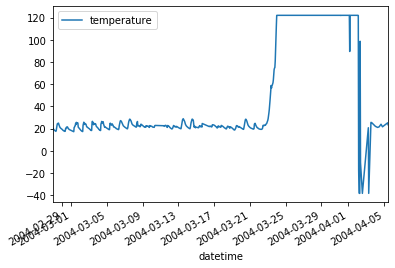

In [10]:
sensor_data.plot(x='datetime', y='temperature')

In [38]:
mote1 = sensor_data[sensor_data['mote_id'] == 1.0 ]
mote1 = mote1[:500]
mote1.head()

,date,time,epoch,mote_id,temperature,humidity,light,voltage,datetime
1,2004-02-28,00:59:16.02785,3,1.0,19.9884,37.0933,45.08,2.69964,2004-02-28 00:00:00
2,2004-02-28,01:03:16.33393,11,1.0,19.3024,38.4629,45.08,2.68742,2004-02-28 01:00:00
54,2004-02-28,02:01:46.132962,128,1.0,18.8712,38.9742,43.24,2.69964,2004-02-28 02:00:00
87,2004-02-28,03:02:17.064743,249,1.0,18.5478,38.9401,43.24,2.67532,2004-02-28 03:00:00
128,2004-02-28,04:00:16.541715,365,1.0,18.2734,39.0422,43.24,2.68742,2004-02-28 04:00:00


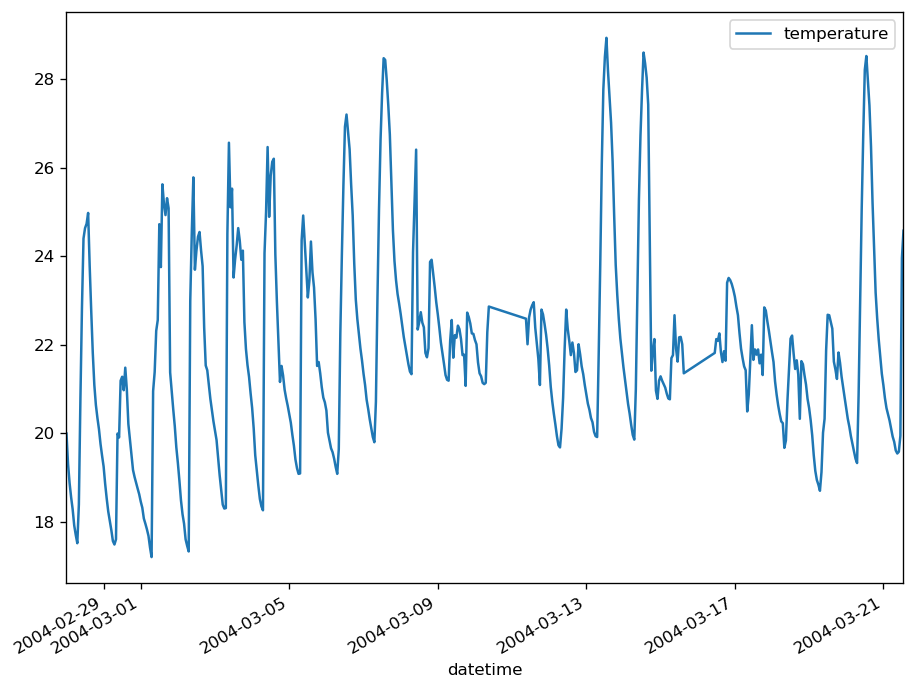

In [39]:
mote1.plot(x='datetime', y='temperature')

In [40]:
mote1.shape

(500, 9)

### Time series prediction with ARIMA
source: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [41]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(mote1['temperature'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.355110
p-value: 0.012588


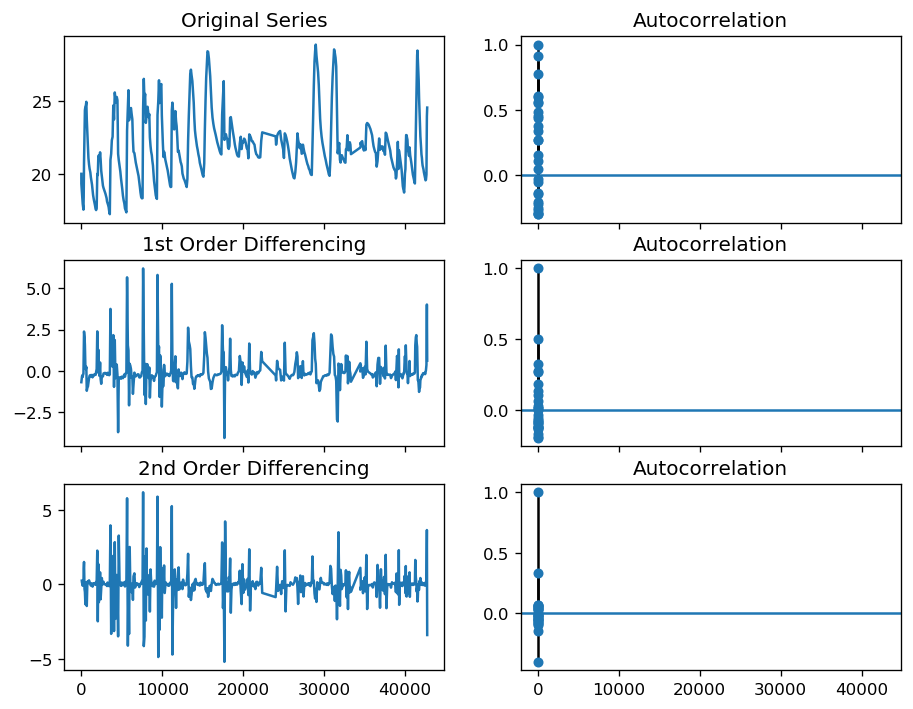

In [42]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(mote1.temperature); axes[0, 0].set_title('Original Series')
plot_acf(mote1.temperature, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(mote1.temperature.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(mote1.temperature.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(mote1.temperature.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(mote1.temperature.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [55]:
# 1,1,2 ARIMA Model
model = ARIMA(mote1.temperature, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.temperature   No. Observations:                  499
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -655.289
Method:                       css-mle   S.D. of innovations              0.900
Date:                Sun, 29 Dec 2019   AIC                           1320.577
Time:                        11:23:27   BIC                           1341.640
Sample:                             1   HQIC                          1328.843
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0094      0.060      0.156      0.876      -0.109       0.128
ar.L1.D.temperature    -0.0227      0.259     -0.088      0.930      -0.530       0.485
ma.L1.D.temperat

/Users/rhoesada/anaconda/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rhoesada/anaconda/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


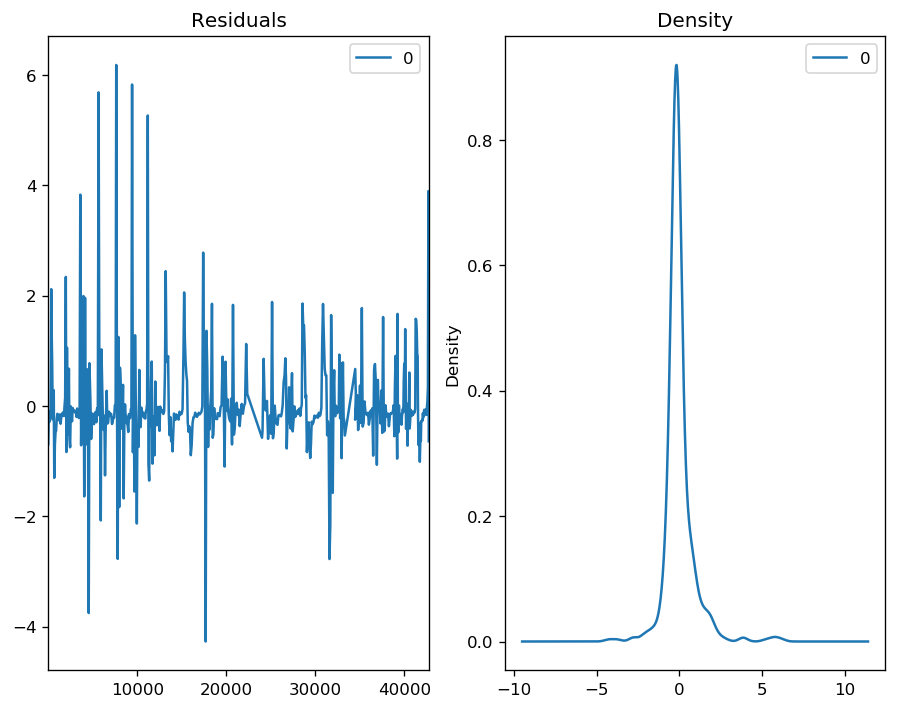

In [56]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

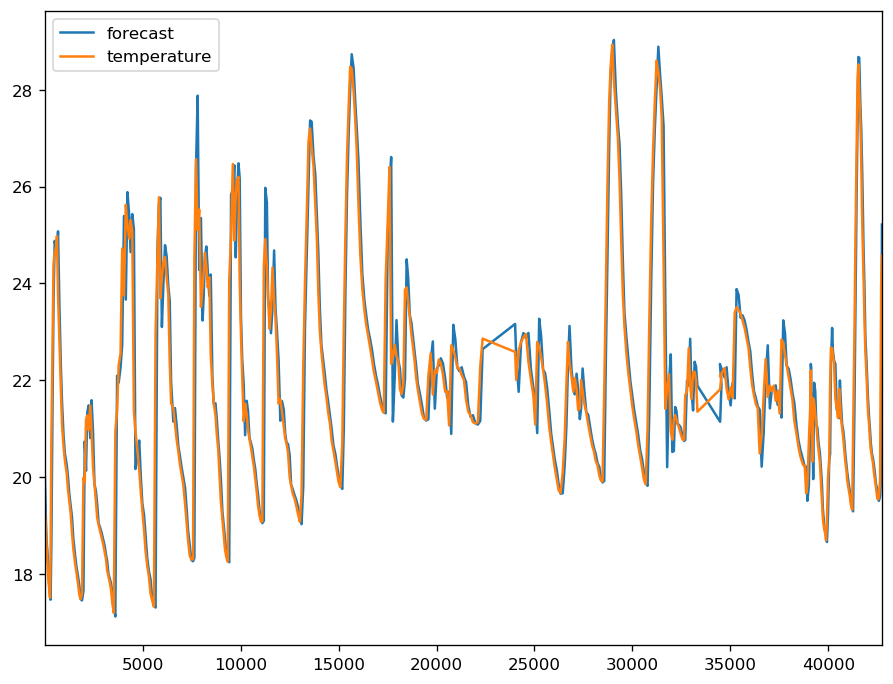

In [57]:
model_fit.plot_predict(dynamic=False)
plt.show()

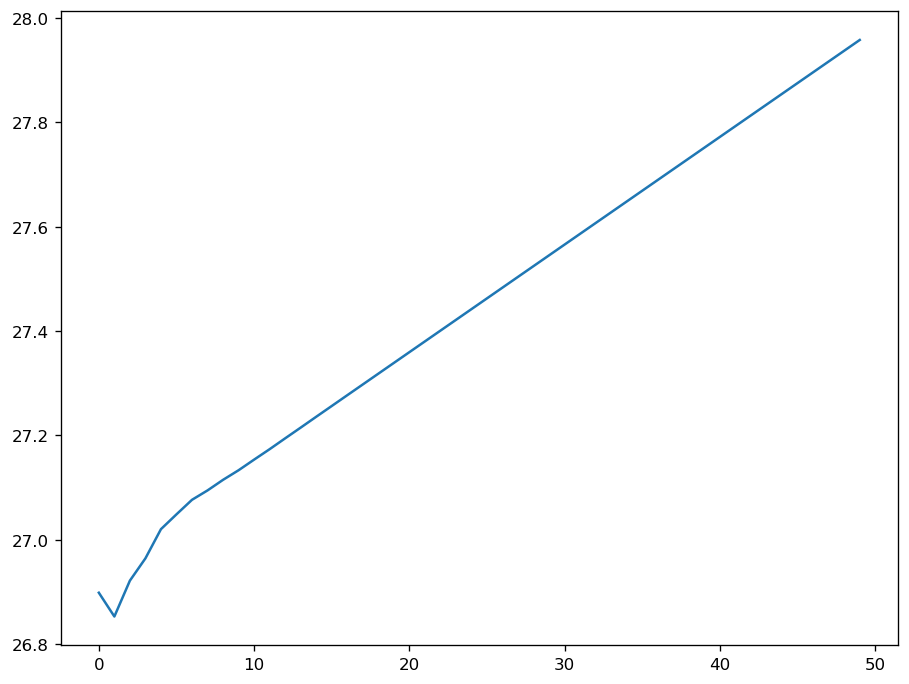

In [86]:
forecast = model_fit.forecast(50)
plt.plot(forecast[0])

/Users/rhoesada/anaconda/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/rhoesada/anaconda/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


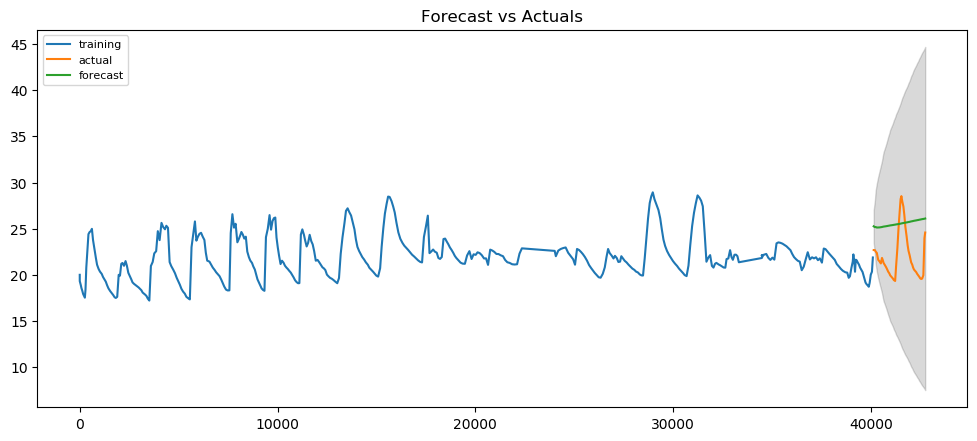

In [69]:
train = mote1.temperature[:450]
test = mote1.temperature[450:]

# Build Model
model = ARIMA(mote1.temperature, order=(3,2,1))  
# model = ARIMA(mote1.temperature, order=(1, 1, 1))  
fitted = model.fit(disp=0)

# Forecast
fc, se, conf = fitted.forecast(50, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()